In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

import plotnine
from plotnine import *
import matplotlib.pyplot as plt

import gc
import os.path
from os import path
import networkx

from research.data.sources import CachedDailyData, TickDB
from research.data.analysis import confusion

from research.functions import MultiFunction1D, SeriesFunction1D, TickFunction1D
from research.core.ggplot import ggcolors
from research.core.ggplot import scale_x_datetime_auto

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 2000)
pd.options.display.max_colwidth = 100

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

1. older sites perform better and the impact outweighs other factors?
2. higher email sends lead to higher pvs. higher social leads to higher pvs?
3. certain words (clickbait or otherwise) lead to higher performance?
4. shorter stories outperform?
5. categories outperform, also that NY/CT vs NJ/PA have a bias on categories they report?
6. there is a sweet spot as to population that a given story should be sent to, however in general that most stories arent being sent to enough pop

# Data Preparation

In [2]:
def categoryFor(x):
    if "Police" in x:
        return "Police & Fire"
    if "Lifestyle" in x:
        return "Lifestyle"
    if "Schools" in x:
        return "Schools"
    if "Obituaries" in x:
        return "Obituaries"
    if "Business" in x:
        return "Business"
    if "Sports" in x:
        return "Sports"
    if "Weather" in x:
        return "Weather"
    if "Politics" in x:
        return "Politics"
    if "Real Estate" in x:
        return "Real Estate"
    else:
        return x
    

In [3]:
df = pd.read_csv("../data/article_data_v3.csv", parse_dates=['publish_datetime'])
df["nviews_geo"] = df["total_pageviews"] / df["population_covered"]
df["primary_category"] = df["primary_category"].apply(categoryFor)
df["clickrate"] = (df["email_clicks"] / df["email_opens"]).fillna(0.0).replace([np.inf], 0.0)
df["openrate"] = (df["email_opens"] / df["email_sends"]).fillna(0.0).replace([np.inf], 0.0).apply(lambda x: min(x,1))
df["email_geo"] = (df["email_sends"] / df["population_covered"]).fillna(0.0).replace([np.inf], 0.0)

# Basic Stats

## % view by population size distribution

/usr/local/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, '% views / population')

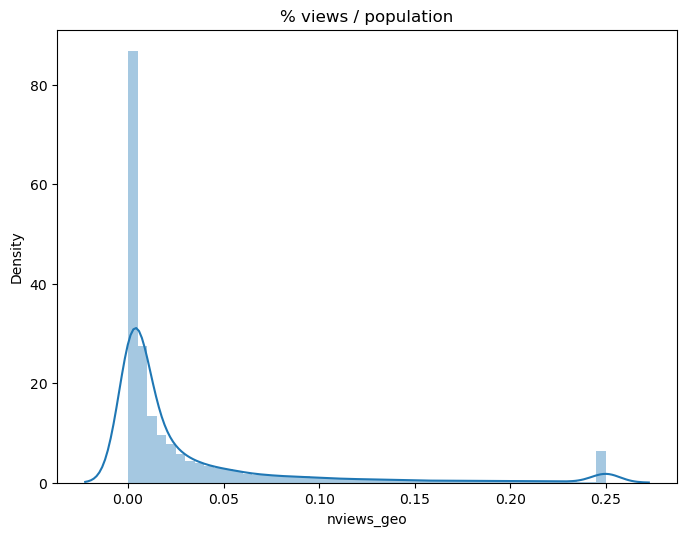

In [308]:
sns.distplot(df["nviews_geo"].apply(lambda x: min(x,0.25))).set_title('% views / population')

In [309]:
df["nviews_geo"].describe()

count    25202.000000
mean         0.041171
std          0.162538
min          0.000000
25%          0.001906
50%          0.006984
75%          0.029476
max         10.525470
Name: nviews_geo, dtype: float64

# Older Sites Perform Better than Newer?

In [275]:
age_relation = df.groupby("primary_site").agg({'primary_site_age': np.mean, 'nviews_geo': np.mean})

In [276]:
pd.concat([
    df.query("primary_site_age < 365").nviews_geo.describe(),
    df.query("primary_site_age >= 365 and primary_site_age < 1500").nviews_geo.describe(),
    df.query("primary_site_age >= 1500").nviews_geo.describe(),
], keys=['< 1 yr', '1-2 yrs', '> 2 yrs'], axis=1)

< 1 yr      1-2 yrs       > 2 yrs
count  7469.000000  7202.000000  10531.000000
mean      0.006472     0.007365      0.088901
std       0.035400     0.015174      0.241385
min       0.000000     0.000000      0.000000
25%       0.000739     0.001381      0.012972
50%       0.002162     0.003196      0.034794
75%       0.005502     0.007536      0.088224
max       2.594834     0.475761     10.525470

# Higher emails lead to more story page views?

- there is a postive correlation between emails and increased story views (though only 43%)

/usr/local/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


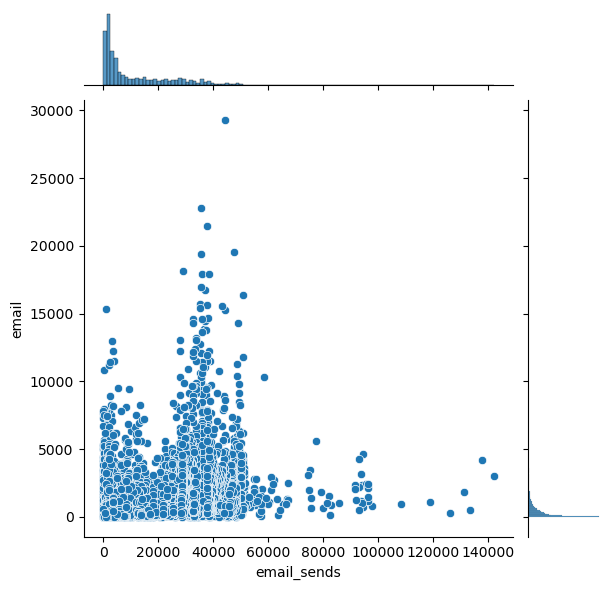

In [277]:
sns.jointplot(df["email_sends"], df["email"])

In [278]:
df[["email_sends","email"]].corr()

email_sends     email
email_sends     1.000000  0.428275
email           0.428275  1.000000

In [279]:
df[["email_sends","email_opens"]].corr()

email_sends  email_opens
email_sends      1.00000      0.59347
email_opens      0.59347      1.00000

In [280]:
df[["email_sends","total_pageviews"]].corr()

email_sends  total_pageviews
email_sends         1.000000         0.066597
total_pageviews     0.066597         1.000000

# Do shorter stories outperform?

- body length __does not__ show any relationship to page view performance of story (3% correlation)
- this makes sense, as people will view a story based on title and then decide how much to read, as the story progresses

/usr/local/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'distribution of body length')

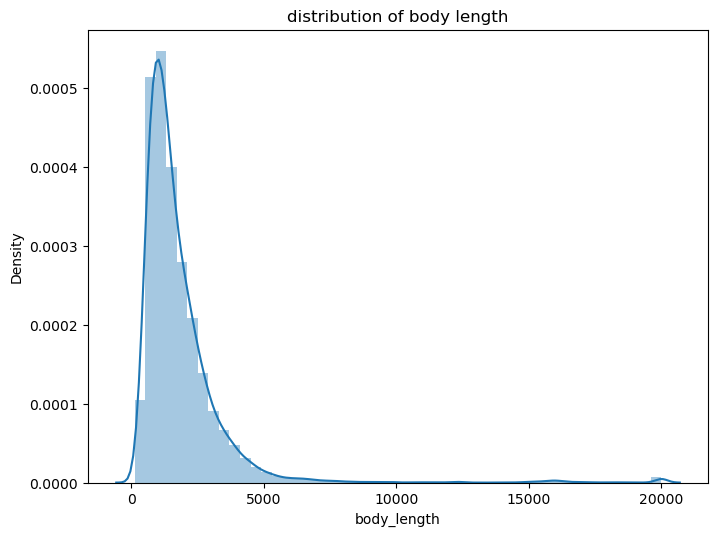

In [324]:
sns.distplot(df["body_length"].apply(lambda x: min(x,20000))).set_title("distribution of body length")

/usr/local/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


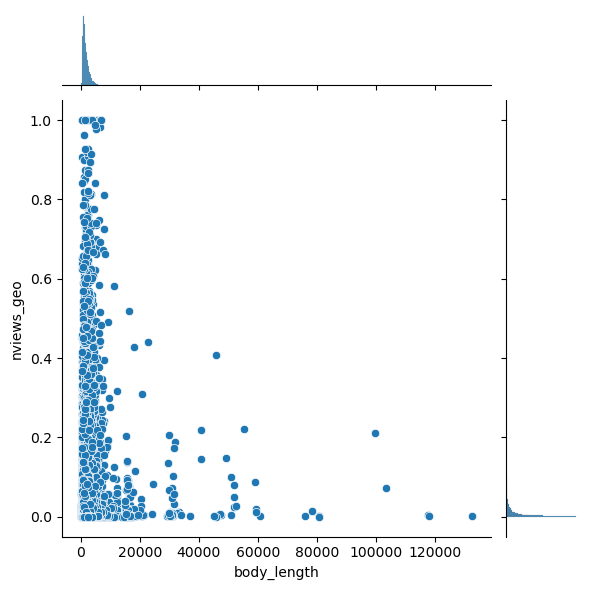

In [326]:
sns.jointplot(df["body_length"],df["nviews_geo"].apply(lambda x: min(x,1)))

In [283]:
df[["body_length","nviews_geo"]].corr()

body_length  nviews_geo
body_length     1.000000    0.035623
nviews_geo      0.035623    1.000000

# Which categories outperform, by geo?

- top absolute # views involve police and fire (but those are the most frequent stories)
- in terms of % views / population, police and fire range below the top 5 in most states

In [284]:
agg = df.groupby (["primary_category"]).nviews_geo.agg(["mean", "count"])
agg.query("count > 5").sort_values("mean", ascending=False)

mean  count
primary_category                 
Schools           0.066937    757
News              0.058629   6517
Events            0.054936     10
Business          0.052768   1123
Obituaries        0.047849    478
Lifestyle         0.040955   1420
Police & Fire     0.031830  13523
Weather           0.031269    451
Real Estate       0.025130    209
Sports            0.021126    135
Politics          0.020616    413
Neighbors         0.016074      8
Traffic           0.014027     82
News, Politics    0.010168     53
News, Traffic     0.003853     13

In [285]:
agg = df.groupby (["primary_state","primary_category"]).nviews_geo.agg(["mean", "count"]).query("count > 5")
agg.sort_values(["primary_state","mean"], ascending=False)

mean  count
primary_state primary_category                 
PA            Weather           0.010223     20
              Obituaries        0.005713     73
              Police & Fire     0.002273   1230
              News              0.002255    141
              Lifestyle         0.001876     75
              Schools           0.001742     22
              Business          0.001630     47
              Real Estate       0.001171      6
              News, Politics    0.000664     12
NY            Business          0.094524    259
              Obituaries        0.091040    144
              Schools           0.086713    301
              News              0.076249   3597
              Lifestyle         0.046845    648
              Weather           0.032048    223
              Police & Fire     0.024001   3682
              Traffic           0.020263     46
              Politics          0.020163    325
              Sports            0.018006     77
              Real Estate       0.016905    162
NJ            Schools           0.081630    257
              Politics          0.074791     15
              Business          0.070190    432
              Real Estate       0.068099     29
              Events            0.059771      9
              News              0.058133   1272
              Lifestyle         0.055405    380
              Police & Fire     0.046375   6607
              Obituaries        0.037823    230
              Sports            0.034890     37
              Weather           0.024937     49
              News, Politics    0.014973     35
              Traffic           0.005814     13
              News, Traffic     0.004618     10
MA            News              0.002453    369
              Business          0.002356    166
              Lifestyle         0.002204     87
              Police & Fire     0.001926    510
              Schools           0.001261     25
              News, Politics    0.001142      6
              Weather           0.000953     32
              Traffic           0.000435      9
CT            Real Estate       0.052768     10
              Weather           0.043297    127
              News              0.028693   1138
              Lifestyle         0.027884    230
              Schools           0.023168    152
              Obituaries        0.023010     27
              Police & Fire     0.021340   1494
              Business          0.018204    219
              Traffic           0.015193      9
              Politics          0.012226     68
              Sports            0.011072     15

# Headlines that drive views

In [315]:
dropwords = [
    'the', 'for', 'at', 'as','of', 'with', 'are', 'was','were','is', 'a', 'an', 'into', 'has', 
    'you','him','her', 'in','to','be','from','on','heres','say','two', "your",
    'connecticut','patterson','paramus','jersey','westchester','hudson','valley', 'fairfield','county', 'bergen',
    'newark','rockland','long', 'island','year','route',"overpeck","ridegwood",
    'northern', 'nj', 'ny', 'ct', 'morris',
    '0','1','2','3','4','5','6','7','8','9',
    '10','11','12','13','14', '15', '16', '19',
    '20','21','22','23','24','25','26','27','28','29',
    '30','31','32','33','34','35','36','37','38','39',
    '40','41','42','43','44','45','46','47','48','49',
    '50','51','52','53','54','55','56','57','58','59',
]

def wordsFor (row):
    stamp = row["publish_datetime"]
    title = str(row["title"])
    state = str(row["primary_state"])
    category = str(row["primary_category"])
    score = float(row["nviews_geo"])
    words = [x.lower() for x in re.findall(r'\w+', title.replace("'",""))]
    filtered = [x for x in words if not x in dropwords]
    return pd.Series([stamp, state, category,filtered,score], index=['stamp','state','category','words','score'])

wordv = df.apply(wordsFor, axis=1)

In [287]:
def filtered (query = "score > 0", by = 'freq'):
    freqs = {}
    counts = {}
    sub = wordv.query (query)
    for i in range(sub.shape[0]):
        words = sub.iloc[i].words
        score = float(sub.iloc[i].score)
        if by == "freq" or np.isnan(score):
            weight = 1
        else:
            weight = int(score * 100)
            
        for word in words:
            if word in freqs:
                freqs[word] += weight
                counts[word] += 1
            else:
                freqs[word] = weight
                counts[word] = 1
        
        if by == "mean1":
            for word in counts.keys():
                freqs[word] = freqs[word] / counts[word]
        elif by == "mean2":
            for word in counts.keys():
                freqs[word] = freqs[word] / np.sqrt(counts[word])
            
    return freqs

## Overall word cloud

In [288]:
allwords = []
for i in range(wordv.shape[0]):
    words = wordv.iloc[i].words
    allwords += words
   

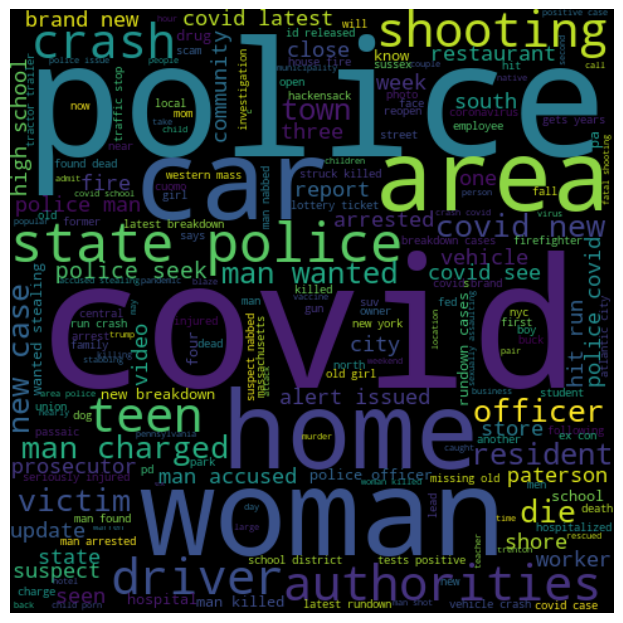

In [289]:
from wordcloud import WordCloud

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(" ".join(allwords))

# Display the generated image:
fig = plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Performance Adjusted: By Cum % of Views

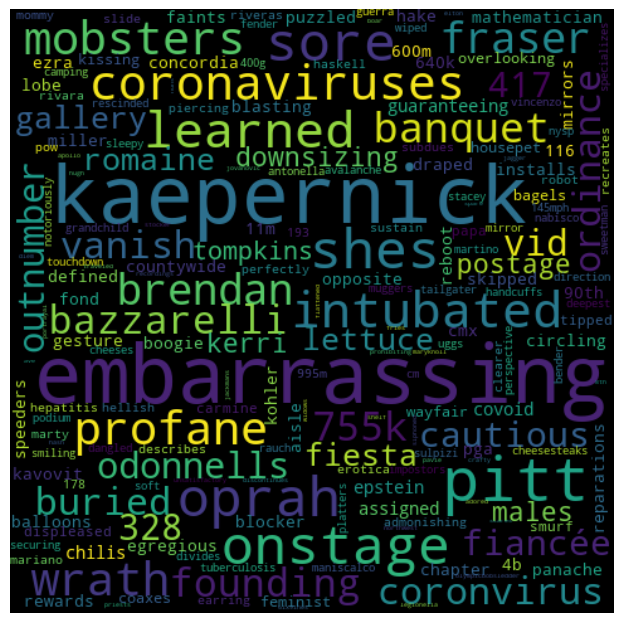

In [290]:
freqs = filtered("score > 0", by='mean1')

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(freqs)

# Display the generated image:
fig = plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

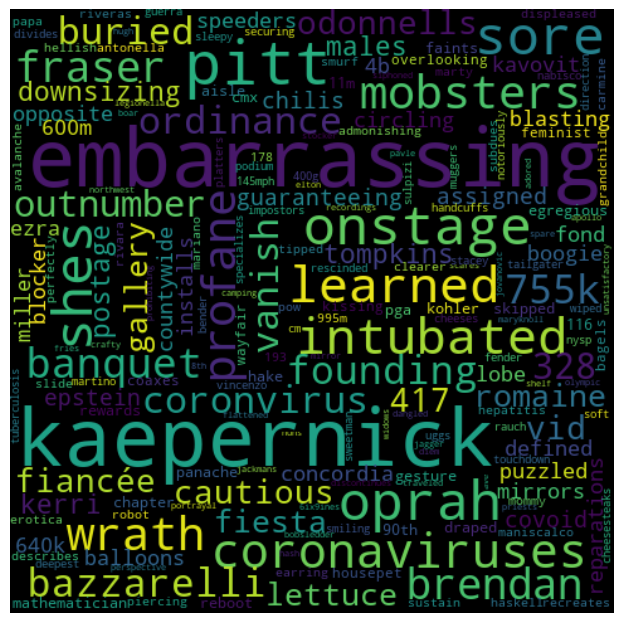

In [291]:
freqs = filtered("score > 0", by='mean2')

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(freqs)

# Display the generated image:
fig = plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

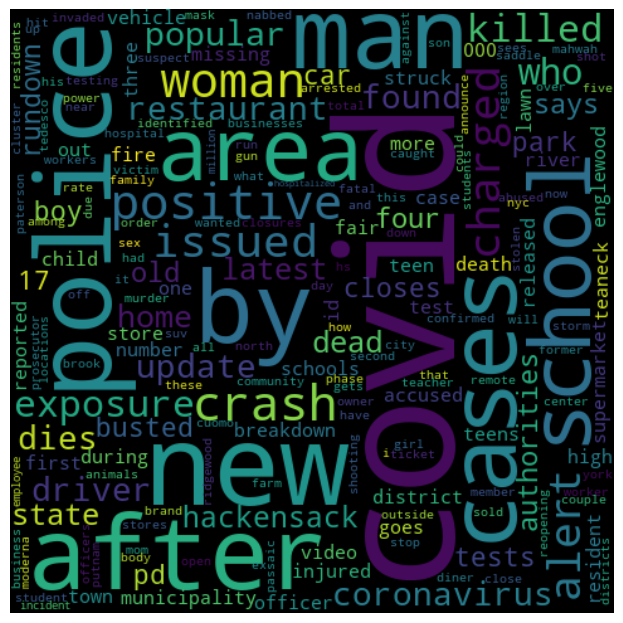

In [292]:
freqs = filtered("score > 0", by='score')

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(freqs)

# Display the generated image:
fig = plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Performance: Police & Fire

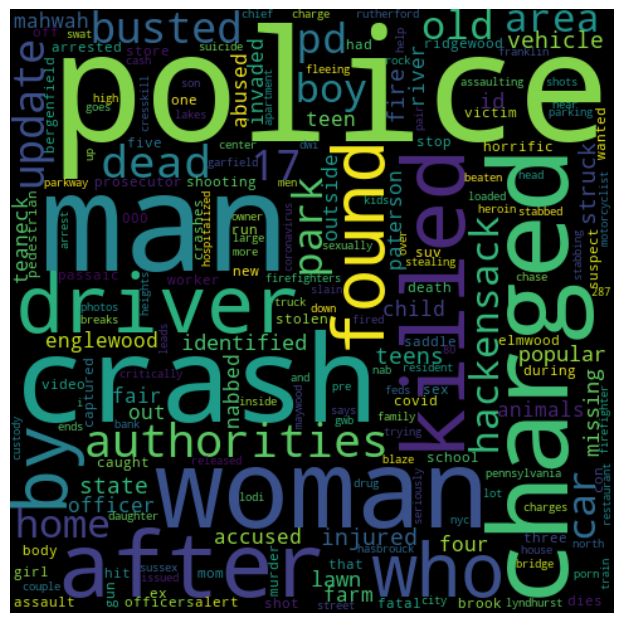

In [293]:
freqs = filtered('category == "Police & Fire"', by='score')

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(freqs)

# Display the generated image:
fig = plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Performance: Schools

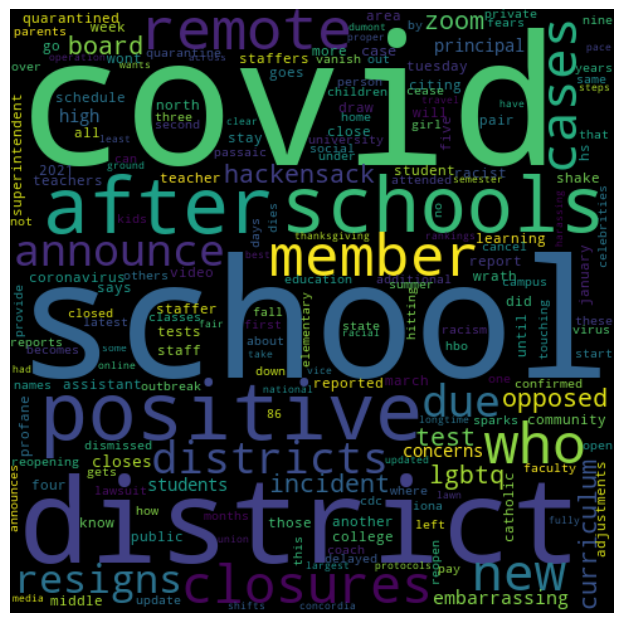

In [294]:
freqs = filtered('category == "Schools"', by='score')

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(freqs)

# Display the generated image:
fig = plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Performance: Business

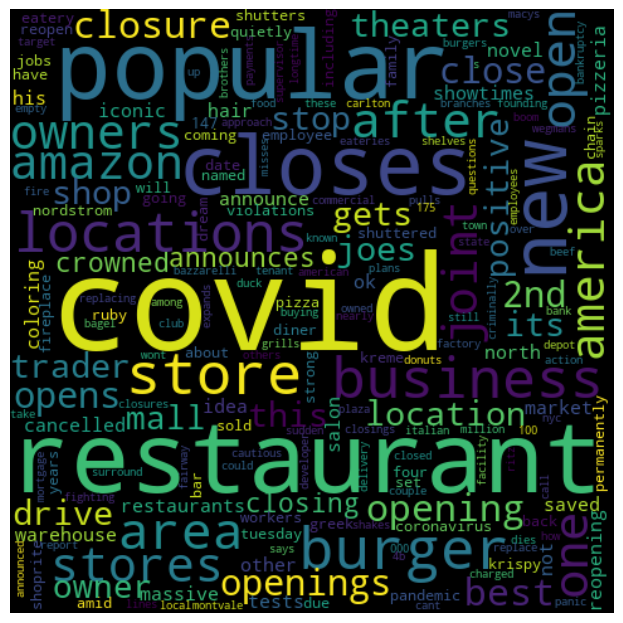

In [295]:
freqs = filtered('category == "Business"', by='score')

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(freqs)

# Display the generated image:
fig = plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Performance: Weather

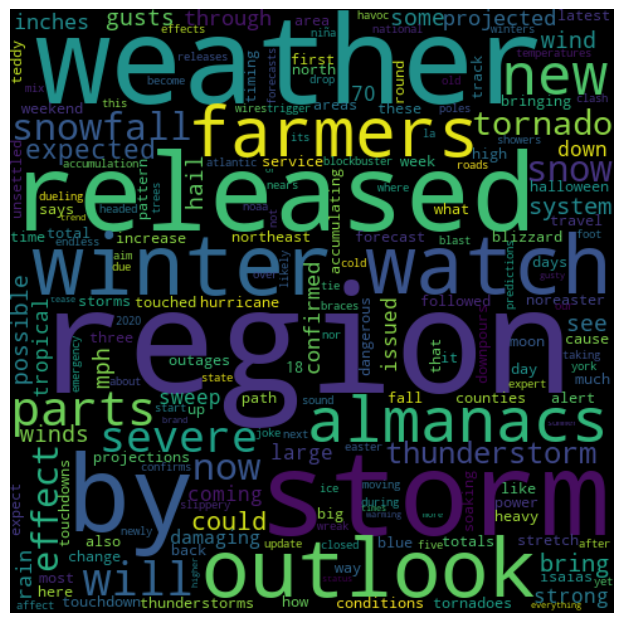

In [311]:
freqs = filtered('category == "Weather"', by='score')

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(freqs)

# Display the generated image:
fig = plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Performance: Events

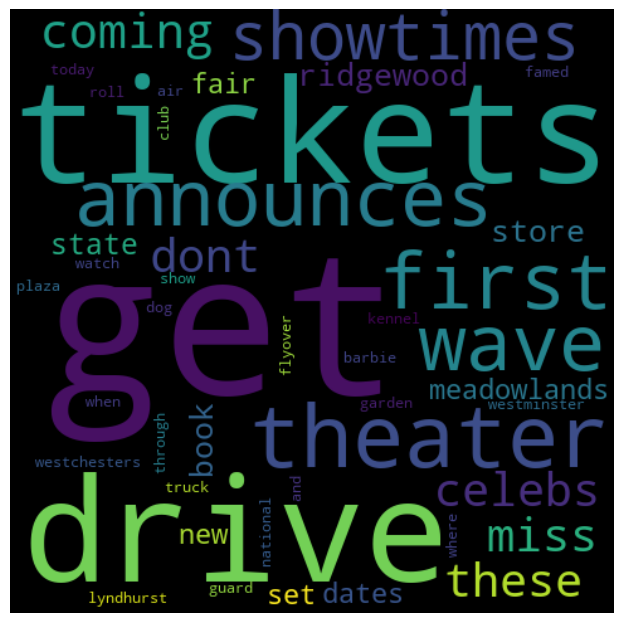

In [316]:
freqs = filtered('category == "Events"', by='score')

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(freqs)

# Display the generated image:
fig = plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Performance: Lifestyle

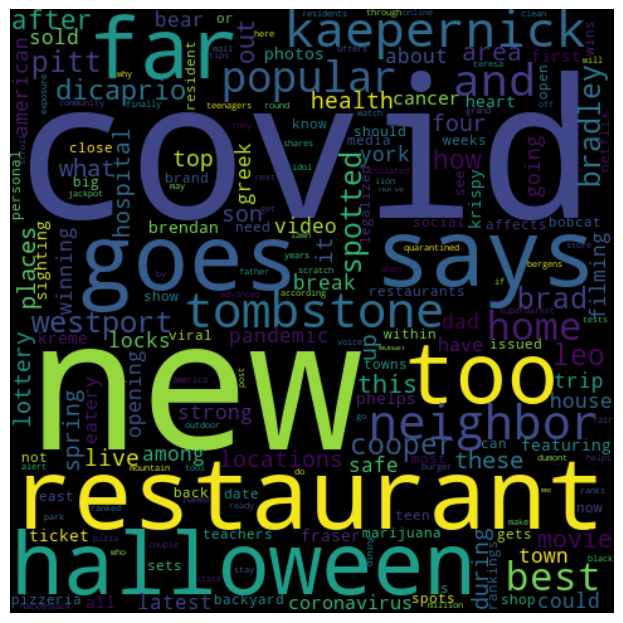

In [317]:
freqs = filtered('category == "Lifestyle"', by='score')

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(freqs)

# Display the generated image:
fig = plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# Differences between NY/CT and NJ/PA

In [320]:
sub = df.query("primary_state != 'MA'").copy()
sub["area"] = sub.primary_state.apply (lambda x: "PANJ" if x == "PA" or x == "NJ" else "NYCT")

## Click rates

In [321]:
sub.groupby("primary_state").clickrate.mean()

primary_state
CT    0.167658
NJ    0.161063
NY    0.176344
PA    0.125623
Name: clickrate, dtype: float64

In [322]:
sub.groupby("primary_state").openrate.mean()

primary_state
CT    0.237808
NJ    0.177021
NY    0.206826
PA    0.110641
Name: openrate, dtype: float64

In [323]:
sub.groupby("primary_state").email_geo.mean()

primary_state
CT    0.025484
NJ    0.027881
NY    0.023573
PA    0.002807
Name: email_geo, dtype: float64

## View rates

In [300]:
sub.groupby("primary_state").nviews_geo.mean()

primary_state
CT    0.024702
NJ    0.049986
NY    0.050223
PA    0.002455
Name: nviews_geo, dtype: float64

In [301]:
agg = sub.groupby (["area","primary_category"]).nviews_geo.agg(["mean", "count"]).query("count > 5")
agg.sort_values(["area","mean"], ascending=False)

mean  count
area primary_category                 
PANJ Schools           0.075331    279
     Politics          0.070125     16
     Business          0.063463    479
     Events            0.059771      9
     Real Estate       0.056626     35
     News              0.052557   1413
     Lifestyle         0.046582    455
     Police & Fire     0.039453   7837
     Sports            0.034056     38
     Obituaries        0.030087    303
     Weather           0.020672     69
     News, Politics    0.011320     47
     Traffic           0.004301     18
     News, Traffic     0.004230     11
NYCT Obituaries        0.080298    171
     Schools           0.065391    453
     News              0.064819   4735
     Business          0.059557    478
     Lifestyle         0.041878    878
     Weather           0.036130    350
     Police & Fire     0.023233   5176
     Traffic           0.019434     55
     Real Estate       0.018990    172
     Politics          0.018790    393
     Sports            0.016876     92

In [310]:
agg = sub.groupby (["area","primary_category"]).total_pageviews.agg(["sum", "count"]).query("count > 5")
agg.sort_values(["area","sum"], ascending=False)

sum  count
area primary_category                 
PANJ Police & Fire     43286162   7838
     News               8660473   1413
     Lifestyle          3444741    455
     Business           3314769    479
     Schools            2742639    279
     Obituaries         1882894    303
     Weather             299016     69
     Real Estate         235159     35
     Sports              161614     38
     News, Politics      113896     47
     Politics             51789     16
     News, Traffic        43186     11
     Events               32225      9
     Traffic              30142     18
NYCT News              43974779   4735
     Police & Fire     16635824   5176
     Weather           11327161    350
     Lifestyle          4567082    883
     Business           3019377    478
     Schools            3008611    473
     Politics           1644665    406
     Obituaries         1005842    171
     Real Estate         350702    172
     Sports              235643     92
     Traffic             207747     55